In [79]:
import pandas as pd
import re
import numpy as np


In [80]:
ruta = 'comentarios_Yamandú Orsi_procesado_Ortografiado_sentimiento_analizado'
df = pd.read_csv(f'{ruta}.csv')

In [81]:
# Para obtener la cantidad de valores únicos
print(f"Cantidad de autores únicos: {df['Autor'].nunique()}")

Cantidad de autores únicos: 10384


In [82]:
conteo_autores = df['Autor'].value_counts()
print(conteo_autores)

Autor
@gracielagonez4260           142
@miguelspera1304              99
@anamariagarciadarosa2517     91
@lilianlamas250               65
@RaulGiacomin-eq6ff           64
                            ... 
@wiliamsanchez8406             1
@AlbertoLepra                  1
@SogfredoMenmdez               1
@juliacuadra7235               1
@vlc8551                       1
Name: count, Length: 10384, dtype: int64


# Análisis Básico por Autor

In [83]:
import pandas as pd


# Agrupar comentarios por autor
grupo_autores = df.groupby('Autor')['Comentario'].agg(['count', ' '.join])

# Top 10 autores más activos
grupo_autores.sort_values('count', ascending=False).head(10)

,count,join
Autor,,
@gracielagonez4260,142,Ripoll bruja Bianca Felicito verónica De Sra l...
@miguelspera1304,99,Joda canelones grande Uruguay quieres ser pres...
@anamariagarciadarosa2517,91,Loquita fosfato quiere cargo en Ripoll quiere ...
@lilianlamas250,65,Quedó muchas dudas también gobierno amigándose...
@RaulGiacomin-eq6ff,64,Caja argentinidad van a recibir esclavos corta...
@juliocancela4254,60,Pregunto cuanto sérum cheque reciben llamados ...
@BeatrizSanchez-f4k,60,Ahora veo da mismo pienso igual vos Depuse gus...
@elcelu4779,58,Bien presidente votos gana diciendo cosas fren...
@gracielacruz7746,55,Ripoll mamadera pico dieron certificada terraj...


##  Detección de Comentarios Duplicados por Autor

In [84]:

from collections import defaultdict

# Diccionario para almacenar comentarios por autor
autores_comentarios = defaultdict(list)

# Agrupar comentarios únicos por autor
for _, row in df.iterrows():
    autores_comentarios[row['Autor']].append(str(row['Comentario']))

# Calcular porcentaje de repetición por autor
resultados = []
for autor, comentarios in autores_comentarios.items():
    total = len(comentarios)
    unicos = len(set(comentarios))
    porcentaje_repeticion = (1 - unicos/total) * 100
    
    resultados.append({
        'Autor': autor,
        'Total_Comentarios': total,
        'Comentarios_Unicos': unicos,
        'Porcentaje_Repeticion': porcentaje_repeticion,
        'Ejemplo_Comentario': max(set(comentarios), key=comentarios.count)  # Comentario más repetido
    })

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)

In [85]:
# Definir umbrales (ajustables)
UMBRAL_REPETICION = 1    # Exigir ≥20% de repetición
UMBRAL_MIN_COMENTARIOS = 2  # Mínimo 5 comentarios para analizar

# Filtrar autores sospechosos
bots_candidatos = df_resultados[
    (df_resultados['Porcentaje_Repeticion'] >= UMBRAL_REPETICION) & 
    (df_resultados['Total_Comentarios'] >= UMBRAL_MIN_COMENTARIOS)
].sort_values('Porcentaje_Repeticion', ascending=False)

print(f"🚨 Posibles bots detectados: {len(bots_candidatos)}")
bots_candidatos[['Autor', 'Porcentaje_Repeticion', 'Total_Comentarios', 'Ejemplo_Comentario']]

🚨 Posibles bots detectados: 7


,Autor,Porcentaje_Repeticion,Total_Comentarios,Ejemplo_Comentario
4701,@coco-nm1gm,50.000000,2,País terrajas
7735,@MonicaDiaz-g1i,50.000000,2,Ahí compañeros
4023,@eduardocrudo7563,20.000000,5,De país generoso
4775,@Raluz57,10.000000,10,Tan solo años desgobierno herreristafascistoid...
1284,@JennyPereira,5.555556,18,Arriba llamando arriba fa
1520,@jorgeluiss-co2os,3.846154,26,Orpí pudiste canelones va a poder país
1123,@robertopy2621,1.960784,51,Bien Sra fiscal aunque zurdos gusté


## Analizar Patrones de Comentarios en Autores Más Activos

<Figure size 2000x1000 with 0 Axes>

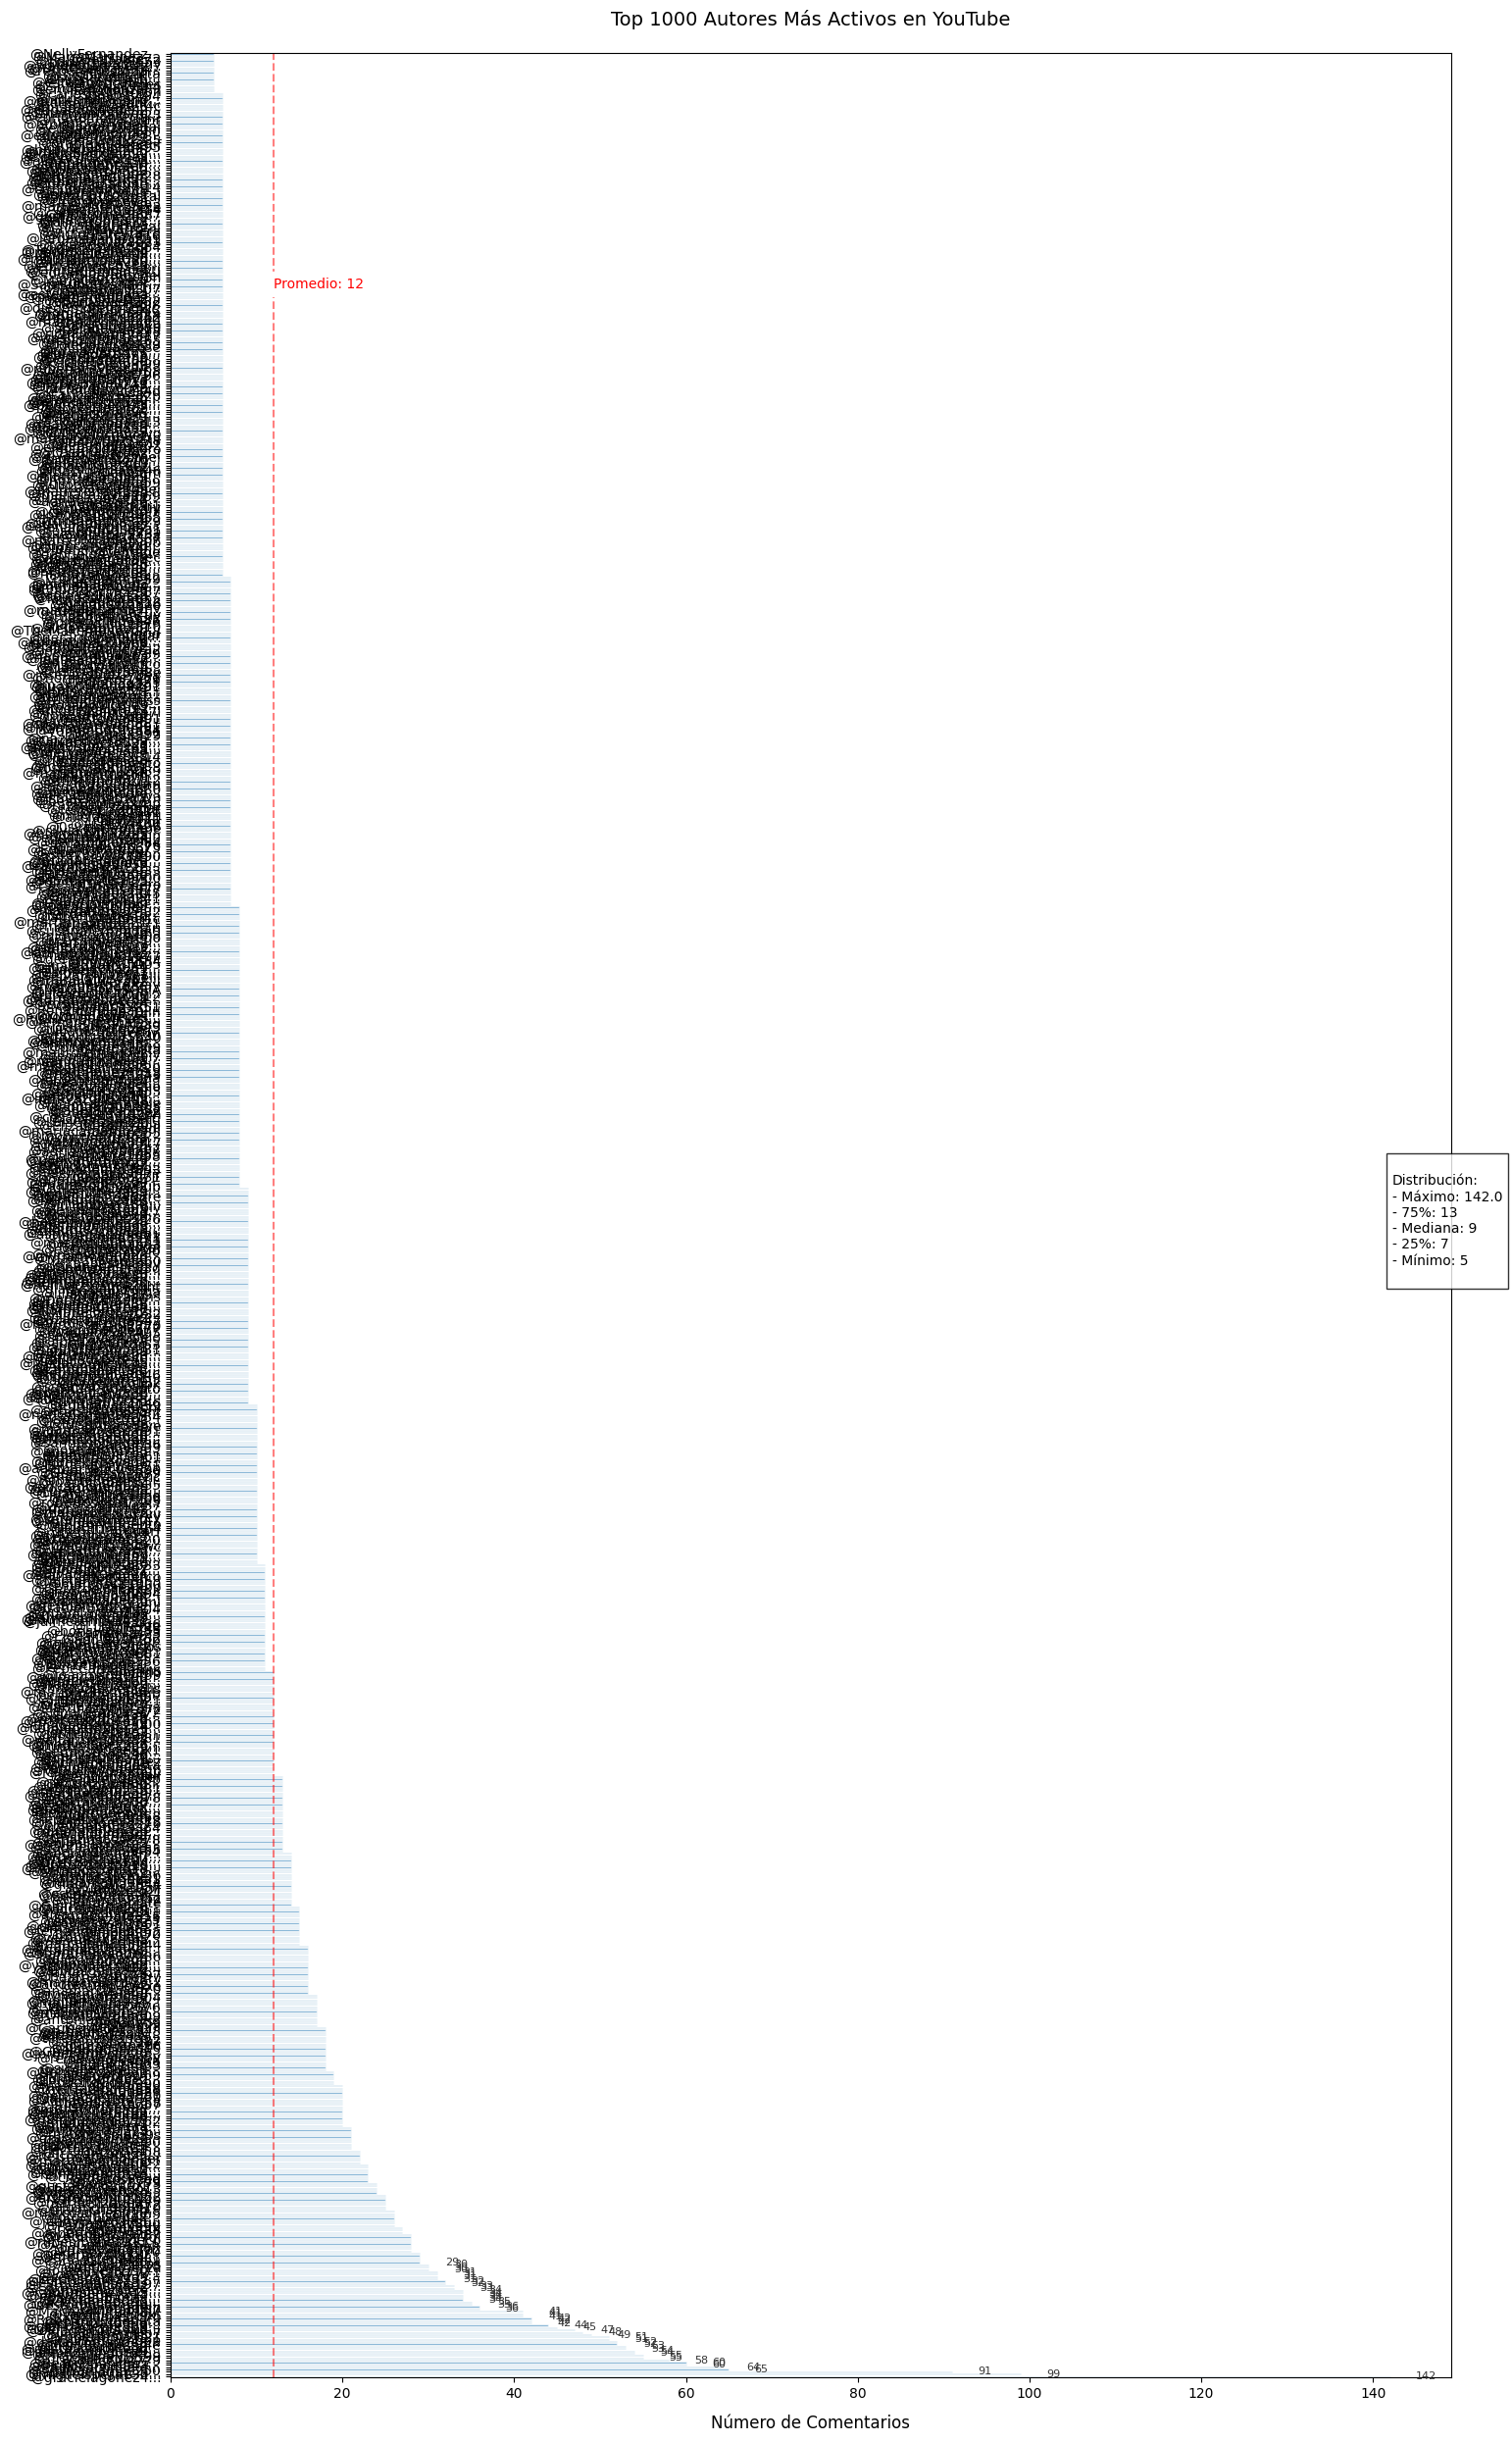

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
# 1. Filtrar autores más activos (top N)
TOP_N = 1000  # Analizar los 100 autores más activos
top_autores = df['Autor'].value_counts().head(TOP_N).index.tolist()

# 2. Función para analizar patrones de un autor
def analizar_autor(autor):
    comentarios = df[df['Autor'] == autor]['Comentario'].tolist()
    
    # Estadísticas básicas
    stats = {
        'Autor': autor,
        'Total_Comentarios': len(comentarios),
        'Comentarios_Unicos': len(set(comentarios)),
        '%_Repeticion': (1 - len(set(comentarios)) / len(comentarios)) * 100,
    }
    
    # Palabras más usadas
    todas_palabras = ' '.join(comentarios).lower()
    palabras = re.findall(r'\b\w+\b', todas_palabras)
    stats['Top_Palabras'] = Counter(palabras).most_common(5)
    
    # Sentimiento promedio
    polaridades = [TextBlob(str(com)).sentiment.polarity for com in comentarios]
    stats['Sentimiento_Promedio'] = sum(polaridades) / len(polaridades)
    
    # Longitud promedio
    longitudes = [len(str(com)) for com in comentarios]
    stats['Longitud_Promedio'] = sum(longitudes) / len(longitudes)
    
    return stats

# 3. Aplicar análisis a los top autores
resultados = [analizar_autor(autor) for autor in top_autores]
df_resultados = pd.DataFrame(resultados)

# 4. Guardar resultados
df_resultados.to_excel("analisis_autores_top.xlsx", index=False)

# 5. Visualización
  # Estilo moderno
plt.figure(figsize=(20, 10))

# Ordenar y seleccionar top 1,000
top_autores = df_resultados.sort_values('Total_Comentarios', ascending=False).head(TOP_N)

# Crear gráfico optimizado
ax = top_autores.plot(
    kind='barh',  # Horizontal para mejor legibilidad
    x='Autor',
    y='Total_Comentarios',
    color='#1f77b4',  # Azul matplotlib
    edgecolor='w',     # Bordes blancos
    alpha=0.7,
    legend=False,
    figsize=(15, 25)  # Tamaño ajustado para 1,000 elementos
)

# Optimización de ejes
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  # Formato numérico
plt.xlabel('Número de Comentarios', fontsize=12, labelpad=10)
plt.ylabel('')
plt.title(f'Top {TOP_N} Autores Más Activos en YouTube', fontsize=14, pad=20)

# Añadir etiquetas de valor (solo a los más relevantes)
for i, (autor, row) in enumerate(top_autores.head(50).iterrows()):  # Solo primeros 50 para evitar saturación
    ax.text(row['Total_Comentarios'] + 3, i, f'{row["Total_Comentarios"]:,}', 
            va='center', fontsize=8, color='#333333')

# Línea vertical de referencia
mean_comments = top_autores['Total_Comentarios'].mean()
ax.axvline(mean_comments, color='red', linestyle='--', alpha=0.5)
ax.text(mean_comments, TOP_N*0.9, f'Promedio: {mean_comments:,.0f}', 
        color='red', ha='left', va='center', backgroundcolor='white')

# Añadir análisis de distribución
boxplot_data = top_autores['Total_Comentarios'].describe()
stats_text = f"""
Distribución:
- Máximo: {boxplot_data["max"]:,}
- 75%: {boxplot_data["75%"]:,.0f}
- Mediana: {boxplot_data["50%"]:,.0f}
- 25%: {boxplot_data["25%"]:,.0f}
- Mínimo: {boxplot_data["min"]:,.0f}
"""
plt.gcf().text(0.95, 0.5, stats_text, bbox=dict(facecolor='white', alpha=0.8), 
              fontsize=10, va='center')

# Optimización de rendimiento para muchos elementos
plt.gca().set_yticklabels([label.get_text()[:15] + '...' if len(label.get_text()) > 15 else label.get_text() 
                          for label in plt.gca().get_yticklabels()])

plt.tight_layout()
 # DPI reducido para archivo más liviano
plt.show()

## Script Avanzado para Detección de Bots en YouTube

C:\Users\HP\AppData\Local\Temp\ipykernel_9972\1770594881.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patrones_temporales = df_sospechosos.groupby('Autor').apply(analizar_patrones_temporales)


🚨 Posibles bots detectados: 1
          Repeticion  Frecuencia  Likes_Promedio  Cluster
Autor                                                    
@Raluz57        10.0   1399252.9             2.3        0


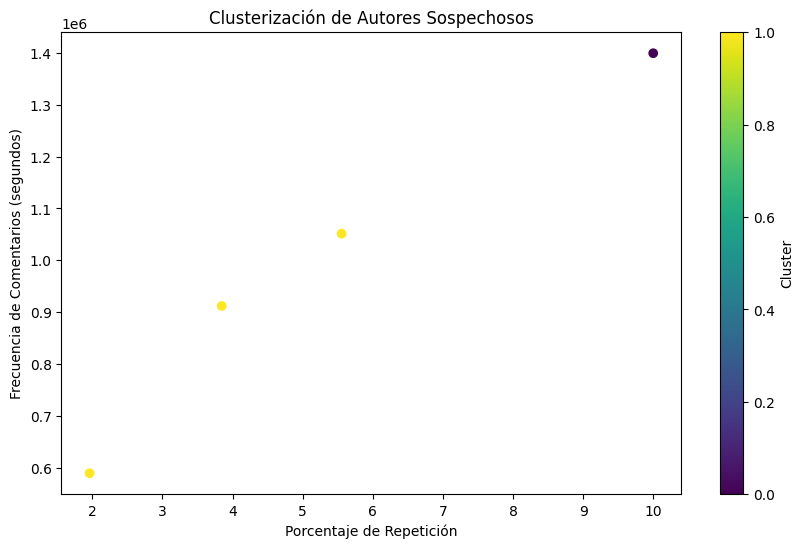

In [88]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# 1. Filtrar autores sospechosos (ej: del df_resultados previo)
autores_sospechosos = df_resultados[df_resultados['%_Repeticion'] > 0]['Autor'].tolist()
df_sospechosos = df[df['Autor'].isin(autores_sospechosos)].copy()

# 2. Análisis Temporal
df_sospechosos['Fecha_Publicacion_Comentario'] = pd.to_datetime(df_sospechosos['Fecha_Publicacion_Comentario'])
df_sospechosos['Hora'] = df_sospechosos['Fecha_Publicacion_Comentario'].dt.hour
df_sospechosos['Dia_Semana'] = df_sospechosos['Fecha_Publicacion_Comentario'].dt.day_name()

# 3. Patrones de Actividad
def analizar_patrones_temporales(grupo):
    return pd.Series({
        'Comentarios_Por_Hora': grupo['Hora'].value_counts().to_dict(),
        'Dias_Activos': grupo['Dia_Semana'].nunique(),
        'Frecuencia_Promedio': (grupo['Fecha_Publicacion_Comentario'].max() - grupo['Fecha_Publicacion_Comentario'].min()).total_seconds() / len(grupo) if len(grupo) > 1 else 0
    })

patrones_temporales = df_sospechosos.groupby('Autor').apply(analizar_patrones_temporales)

# 4. Análisis de Contenido
def analizar_contenido(comentarios):
    blob = TextBlob(" ".join(comentarios.astype(str)))
    return pd.Series({
        'Diversidad_Lexica': len(set(" ".join(comentarios).split())) / len(" ".join(comentarios).split()),
        'Palabras_Clave': Counter(" ".join(comentarios).lower().split()).most_common(3),
        'Coherencia_Tematica': np.mean([TextBlob(str(c)).sentiment.polarity for c in comentarios])
    })

analisis_contenido = df_sospechosos.groupby('Autor')['Comentario'].apply(analizar_contenido)

# 5. Análisis de Engagement
engagement = df_sospechosos.groupby('Autor').agg({
    'Likes_Comentario': ['mean', 'median'],
    'Numero_Views': 'first',
    'Numero_Likes': 'first'
})

# 6. Clusterización para Detección de Bots
features = pd.DataFrame({
    'Repeticion': df_resultados.set_index('Autor')['%_Repeticion'],
    'Frecuencia': patrones_temporales['Frecuencia_Promedio'],
   
    'Likes_Promedio': engagement[('Likes_Comentario', 'mean')]
}).dropna()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=2, random_state=42)
features['Cluster'] = kmeans.fit_predict(features_scaled)

# 7. Identificación de Bots
bots_candidatos = features[features['Cluster'] == features['Cluster'].value_counts().idxmin()]
print(f"🚨 Posibles bots detectados: {len(bots_candidatos)}")
print(bots_candidatos.sort_values('Repeticion', ascending=False).head())

# 8. Visualización
plt.figure(figsize=(10, 6))
plt.scatter(features['Repeticion'], features['Frecuencia'], c=features['Cluster'], cmap='viridis')
plt.xlabel('Porcentaje de Repetición')
plt.ylabel('Frecuencia de Comentarios (segundos)')
plt.title('Clusterización de Autores Sospechosos')
plt.colorbar(label='Cluster')
plt.show()

# 9. Exportar Resultados
bots_candidatos.to_excel("bots_candidatos.xlsx")